In [1]:
import anndata
import numpy as np
import scipy as sp
import scvelo as scv
import scanpy as sc
import sys

import pandas as pd
import torch
import os
sys.path.append('../')
import topovelo as tpv
import matplotlib.pyplot as plt
from scipy.io import mmread, mmwrite

from numpy import savetxt
%load_ext autoreload
%autoreload 2

In [2]:
dataset = 'stereo-seq-gut'
data_path_base = '/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/stereo_seq/gut_e10.5_13.5'
figure_path_base = '/nfs/turbo/umms-welchjd/yichen/figures/TopoVelo/stereo_seq/gut_e10.5_13.5'
model_path_base = '/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/stereo_seq/gut_e10.5_e13.5/checkpoints'

In [3]:
# adata = anndata.read_h5ad(f'{data_path_base}/adata_pp.h5ad')
adata = anndata.read_h5ad(f'{data_path_base}/adata_batchcorrected_out.h5ad')

In [4]:
scv.pl.scatter(adata, basis='spatial', figsize=(12, 3))

# TopoVelo

Assign an informative time prior based on real time.

In [4]:
tprior = np.zeros((adata.n_obs))
batch = adata.obs['batch'].to_numpy()
tprior[batch == '0'] = 10.5
tprior[batch == '1'] = 11.5
tprior[batch == '2'] = 12.5
tprior[batch == '3'] = 13.5
adata.obs['tprior'] = tprior

genes = ['Hmga2', 'Rbp1', 'Meis1', 'Acta2']
[x in adata.var_names for x in genes]

[True, True, True, True]

In [7]:
figure_path = f'{figure_path_base}/tpv_batch'
model_path = f'{model_path_base}/tpv_batch'

torch.manual_seed(2022)
np.random.seed(2022)

vae = tpv.VAE(adata, 
              tmax=20, 
              dim_z=10, 
              dim_cond=4,
              device='cuda:0',
              #init_method='tprior',
              #init_key='tprior',
              #tprior='tprior',
              ref_batch=3,
              batch_key='batch',
              graph_decoder=True,
              attention=False,
              reverse_gene_mode=True)
config = {
    'n_epochs':2000,
    'learning_rate': 2e-4,
    'learning_rate_ode': 2e-3,
    'learning_rate_post': 2e-4
}
vae.train(adata,
          adata.obsp['spatial_graph'],
          'X_spatial',
          config=config,
          plot=False,
          gene_plot=genes,
          figure_path=figure_path,
          embed='spatial')
# vae.save_model(model_path, 'encoder', 'decoder')
vae.save_anndata(adata, 'tpv', data_path_base, file_name="adata_batchcorrected_out.h5ad")

CVAE enabled. Performing batch effect correction.
Reference batch set to 3 (3).
Initialization using the steady-state and dynamical models.
Computing scaling_u factors for each batch class.
0.6709158000670916
Estimating ODE parameters...


  0%|          | 0/2981 [00:00<?, ?it/s]

Detected 653 velocity genes.
Estimating the variance...


  0%|          | 0/2981 [00:00<?, ?it/s]

4 clusters detected based on gene co-expression.
(0.58, 0.6987317450324094), (0.42, 0.23083818477878607)
(0.51, 0.6896721532232725), (0.49, 0.2569302442439517)
(0.50, 0.7609877299919241), (0.50, 0.2869275716389692)
(0.44, 0.34125874322429484), (0.56, 0.768217490251207)
KS-test result: [0. 0. 0. 0.]
Initial induction: 1378, repression: 1603/2981
Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/2981 [00:00<?, ?it/s]

--------------------------- Train a TopoVelo ---------------------------
*********               Creating a Graph Dataset              *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
*********       Stage 1: Early Stop Triggered at epoch 98.       *********
Summary: 
Train ELBO = 4820.870
Test ELBO = 4697.351
Total Time =   0 h :  6 m : 27 s

*********                      Stage  2                       *********
*********             Velocity Refinement Round 1              *********


  0%|          | 0/6366 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.030
Average Neighborhood Size: 162.4
Average Set Size: 14.3
Summary: 
Train ELBO = 9057.533
Test ELBO = 8937.233
Total Time =   0 h : 10 m :  5 s

*********       Round 1: Early Stop Triggered at epoch 165.       *********
Change in noise variance: 0.4638
*********             Velocity Refinement Round 2              *********
Summary: 
Train ELBO = 9100.016
Test ELBO = 8932.858
Total Time =   0 h : 11 m :  8 s

*********       Round 2: Early Stop Triggered at epoch 185.       *********
Change in noise variance: 0.0002
Change in x0: 0.0588
*********             Velocity Refinement Round 3              *********
Summary: 
Train ELBO = 8684.392
Test ELBO = 8935.729
Total Time =   0 h : 12 m :  5 s

*********       Round 3: Early Stop Triggered at epoch 203.       *********
Change in noise variance: 0.0000
Change in x0: 0.0419
*********             Velocity Refinement Round 4              *********
Summary: 
Train ELBO = 8998.112
Test ELBO = 8933.269
Total Ti

VAE with graph attention

In [8]:
figure_path = f'{figure_path_base}/gat_batch'
model_path = f'{model_path_base}/gat_batch'

torch.manual_seed(2022)
np.random.seed(2022)

vae = tpv.VAE(adata, 
              tmax=20, 
              dim_z=10, 
              dim_cond=4,
              device='cuda:0',
              #init_method='tprior',
              #init_key='tprior',
              #tprior='tprior',
              ref_batch=3,
              batch_key='batch',
              graph_decoder=True,
              attention=True,
              reverse_gene_mode=True)
config = {
    'learning_rate': 2e-4,
    'learning_rate_ode': 2e-3,
    'learning_rate_post': 2e-4,
}
vae.train(adata,
          adata.obsp['spatial_graph'],
          'X_spatial',
          config=config,
          plot=False,
          figure_path=figure_path,
          embed='spatial')
vae.save_model(model_path, 'encoder', 'decoder')
vae.save_anndata(adata, 'gat', data_path_base, file_name="adata_batchcorrected_out.h5ad")

CVAE enabled. Performing batch effect correction.
Reference batch set to 3 (3).
Initialization using the steady-state and dynamical models.
Computing scaling_u factors for each batch class.
0.6709158000670916
Estimating ODE parameters...


  0%|          | 0/2981 [00:00<?, ?it/s]

Detected 653 velocity genes.
Estimating the variance...


  0%|          | 0/2981 [00:00<?, ?it/s]

4 clusters detected based on gene co-expression.
(0.58, 0.6987317450324094), (0.42, 0.23083818477878607)
(0.51, 0.6896721532232725), (0.49, 0.2569302442439517)
(0.50, 0.7609877299919241), (0.50, 0.2869275716389692)
(0.44, 0.34125874322429484), (0.56, 0.768217490251207)
KS-test result: [0. 0. 0. 0.]
Initial induction: 1378, repression: 1603/2981
Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/2981 [00:00<?, ?it/s]

--------------------------- Train a TopoVelo ---------------------------
*********               Creating a Graph Dataset              *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
*********       Stage 1: Early Stop Triggered at epoch 311.       *********
Summary: 
Train ELBO = 5133.440
Test ELBO = 5134.974
Total Time =   0 h : 52 m : 31 s

*********                      Stage  2                       *********
*********             Velocity Refinement Round 1              *********


  0%|          | 0/6366 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.037
Average Neighborhood Size: 162.4
Average Set Size: 16.5
Summary: 
Train ELBO = 9369.508
Test ELBO = 9537.764
Total Time =   0 h : 58 m :  5 s

*********       Round 1: Early Stop Triggered at epoch 345.       *********
Change in noise variance: 0.4996
*********             Velocity Refinement Round 2              *********
Summary: 
Train ELBO = 9373.758
Test ELBO = 9492.907
Total Time =   0 h : 59 m : 24 s

*********       Round 2: Early Stop Triggered at epoch 353.       *********
Change in noise variance: 0.0003
Change in x0: 0.0957
*********             Velocity Refinement Round 3              *********
Summary: 
Train ELBO = 9770.241
Test ELBO = 9433.299
Total Time =   1 h :  2 m : 19 s

*********       Round 3: Early Stop Triggered at epoch 371.       *********
Change in noise variance: 0.0000
Change in x0: 0.0865
*********             Velocity Refinement Round 4              *********
Stage 2: Early Stop Triggered at round 3.
*********          

# scVelo

In [7]:
scv.pp.neighbors(adata)
scv.tl.recover_dynamics(adata, n_jobs=12)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)
scv.tl.latent_time(adata)

computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
recovering dynamics (using 12/32 cores)


  0%|          | 0/1872 [00:00<?, ?gene/s]

    finished (0:09:40) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:21) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/32 cores)


  0%|          | 0/6366 [00:00<?, ?cells/s]

    finished (0:01:42) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing latent time using root_cells as prior
    finished (0:00:06) --> added 
    'latent_time', shared time (adata.obs)


In [8]:
adata.write_h5ad(f'{data_path_base}/adata_batchcorrected_out.h5ad')

In [25]:
adata = anndata.read_h5ad(f'{data_path_base}/adata_batchcorrected_out.h5ad')

['Snapc3']
---   Plotting  Results   ---


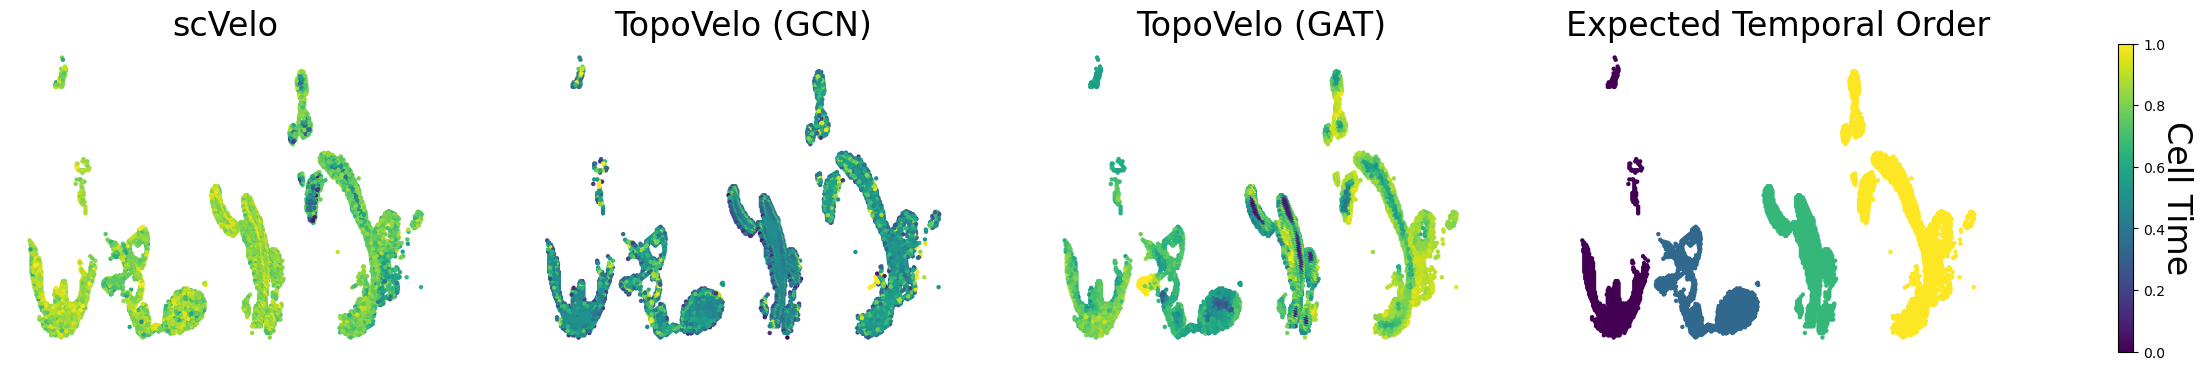

In [9]:
(res, res_type,
 res_multi, res_multi_type) = tpv.post_analysis(adata,
                                                'gut',
                                                ['scVelo', 'TopoVelo (GCN)', 'TopoVelo (GAT)'],
                                                ['fit', 'tpv', 'gat'],
                                                spatial_graph_key='spatial_graph',
                                                spatial_key='X_spatial',
                                                compute_metrics=False,
                                                spatial_velocity_graph=True,
                                                embed='spatial',
                                                plot_type=['time'],
                                                dot_size=10,
                                                time_colormap='viridis',
                                                cluster_edges=[('Epithelial', 'Mesenchymal')],
                                                figure_path=figure_path_base)

Sparisty: u=0.527s=0.333
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
['Snapc3']
---   Plotting  Results   ---
computing velocity graph (using 1/32 cores)


  0%|          | 0/1088 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'gat_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'gat_velocity_spatial', embedded velocity vectors (adata.obsm)
saving figure to file /nfs/turbo/umms-welchjd/yichen/figures/TopoVelo/stereo_seq/gut_e10.5_13.5/batchcorrected_gut_e10.5_gat.png


saving figure to file /nfs/turbo/umms-welchjd/yichen/figures/TopoVelo/stereo_seq/gut_e10.5_13.5/batchcorrected_gut_e10.5_gat_true_velocity.png


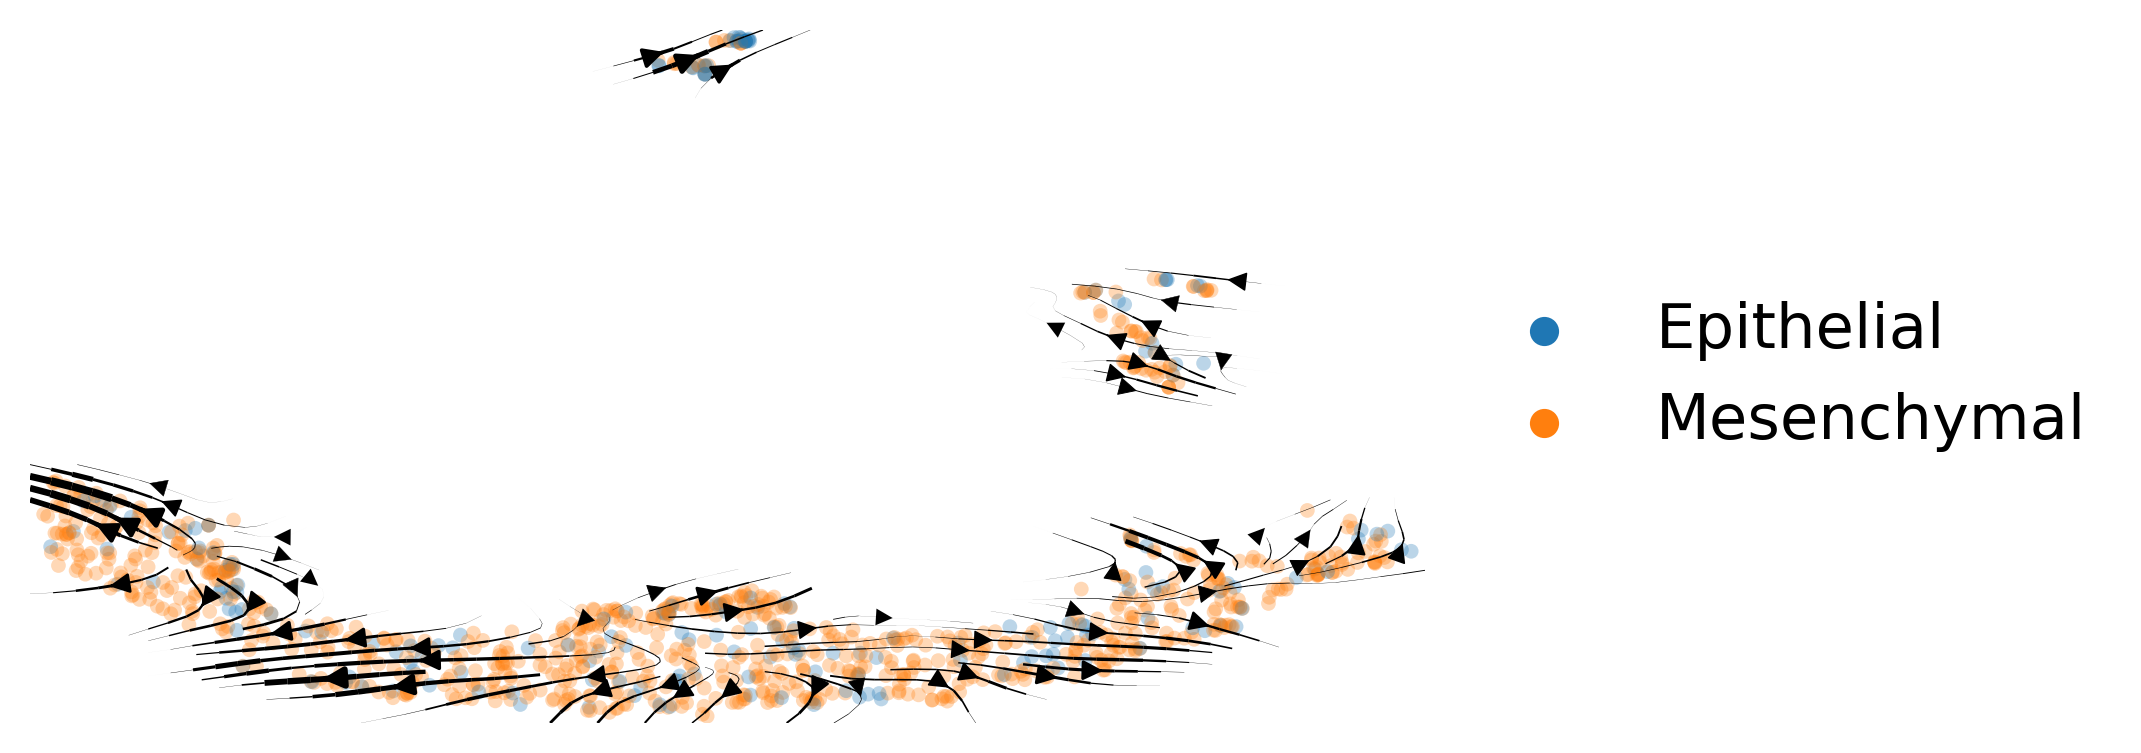

Sparisty: u=0.907s=0.856
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
['Snapc3']
---   Plotting  Results   ---
computing velocity graph (using 1/32 cores)


  0%|          | 0/1426 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'gat_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'gat_velocity_spatial', embedded velocity vectors (adata.obsm)
saving figure to file /nfs/turbo/umms-welchjd/yichen/figures/TopoVelo/stereo_seq/gut_e10.5_13.5/batchcorrected_gut_e11.5_gat.png


saving figure to file /nfs/turbo/umms-welchjd/yichen/figures/TopoVelo/stereo_seq/gut_e10.5_13.5/batchcorrected_gut_e11.5_gat_true_velocity.png


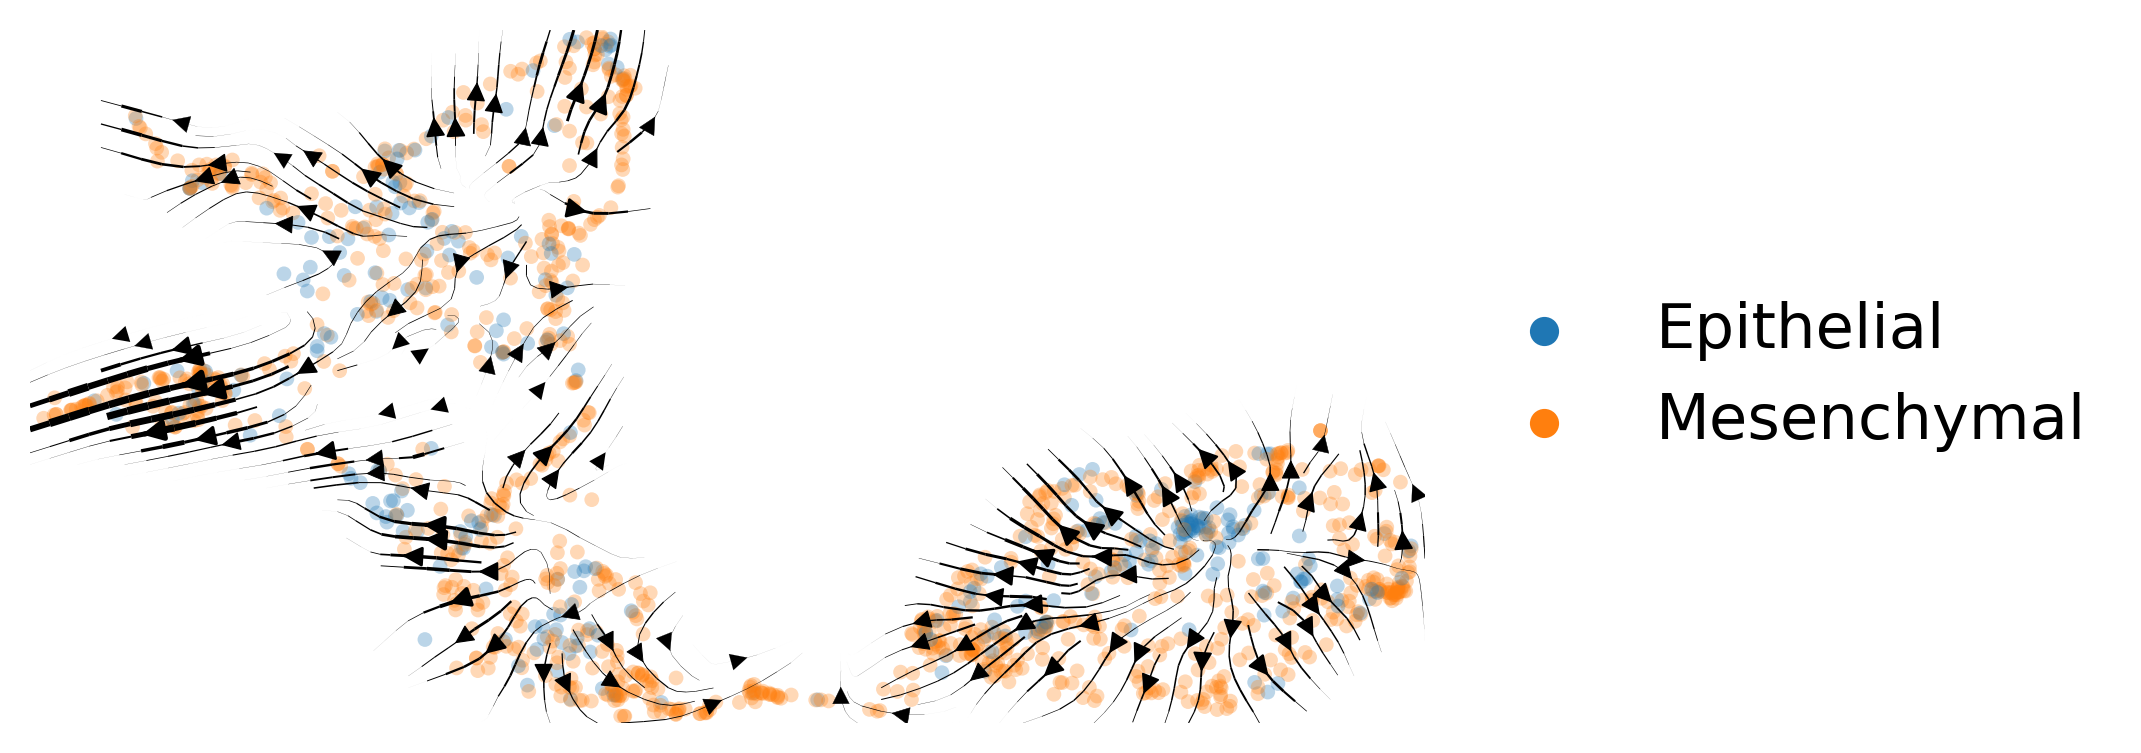

Sparisty: u=0.503s=0.398
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
['Snapc3']
---   Plotting  Results   ---
computing velocity graph (using 1/32 cores)


  0%|          | 0/1471 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'gat_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'gat_velocity_spatial', embedded velocity vectors (adata.obsm)
saving figure to file /nfs/turbo/umms-welchjd/yichen/figures/TopoVelo/stereo_seq/gut_e10.5_13.5/batchcorrected_gut_e12.5_gat.png


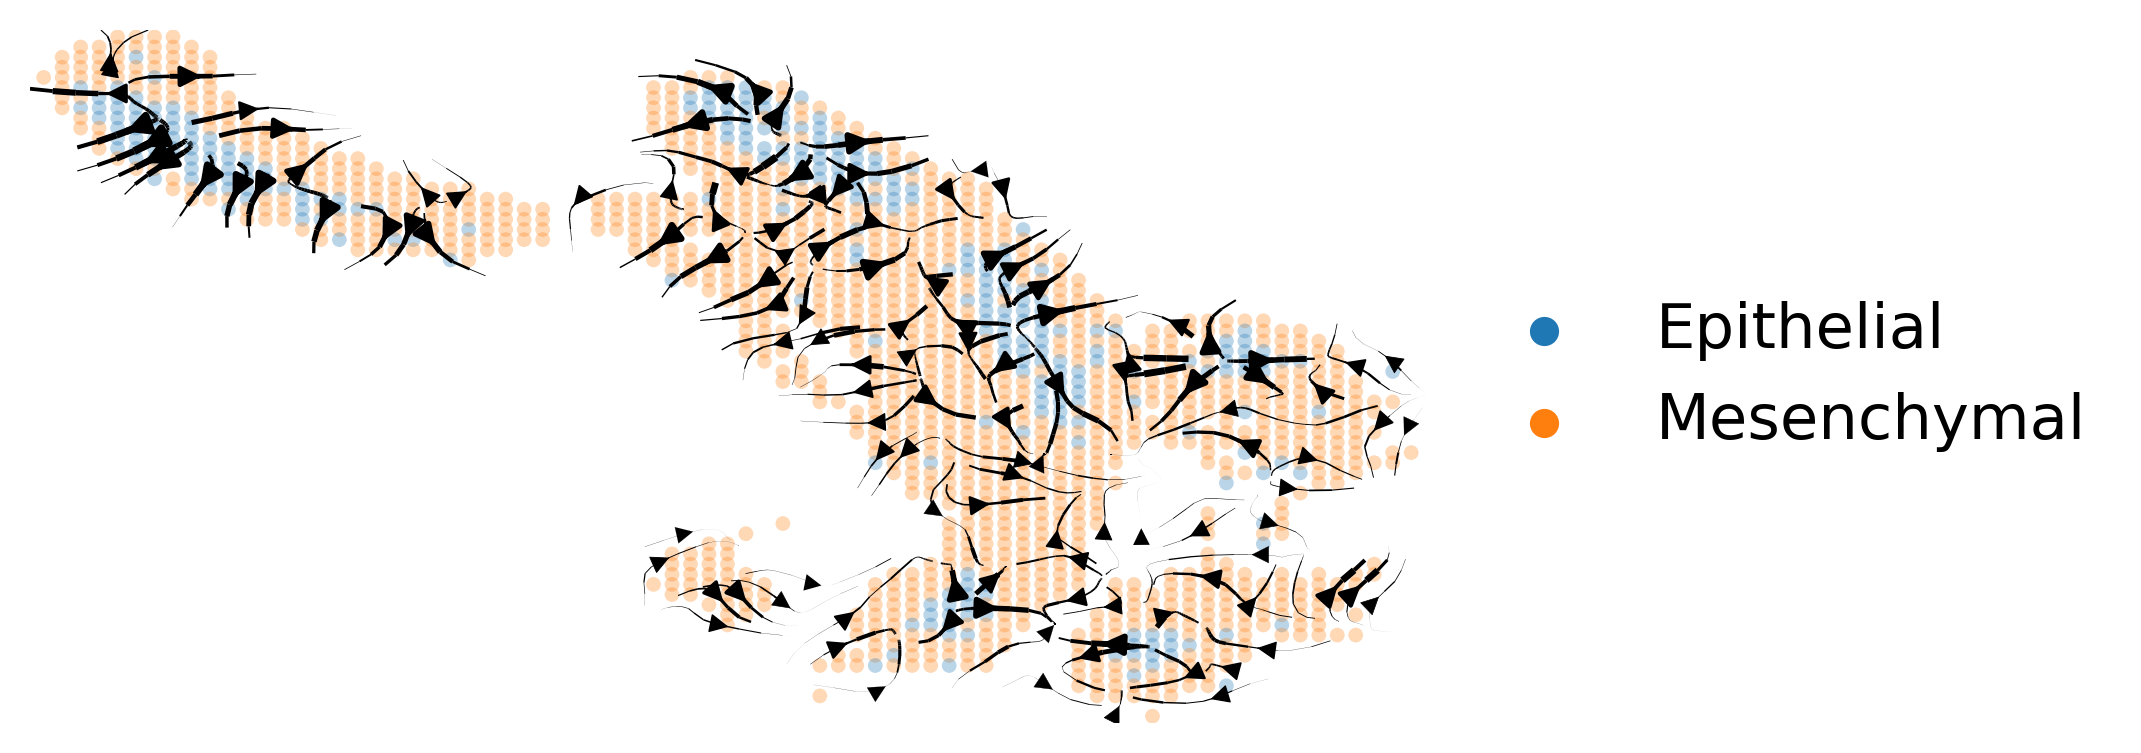

saving figure to file /nfs/turbo/umms-welchjd/yichen/figures/TopoVelo/stereo_seq/gut_e10.5_13.5/batchcorrected_gut_e12.5_gat_true_velocity.png


Sparisty: u=0.562s=0.342
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
['Snapc3']
---   Plotting  Results   ---
computing velocity graph (using 1/32 cores)


  0%|          | 0/2381 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'gat_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'gat_velocity_spatial', embedded velocity vectors (adata.obsm)
saving figure to file /nfs/turbo/umms-welchjd/yichen/figures/TopoVelo/stereo_seq/gut_e10.5_13.5/batchcorrected_gut_e13.5_gat.png


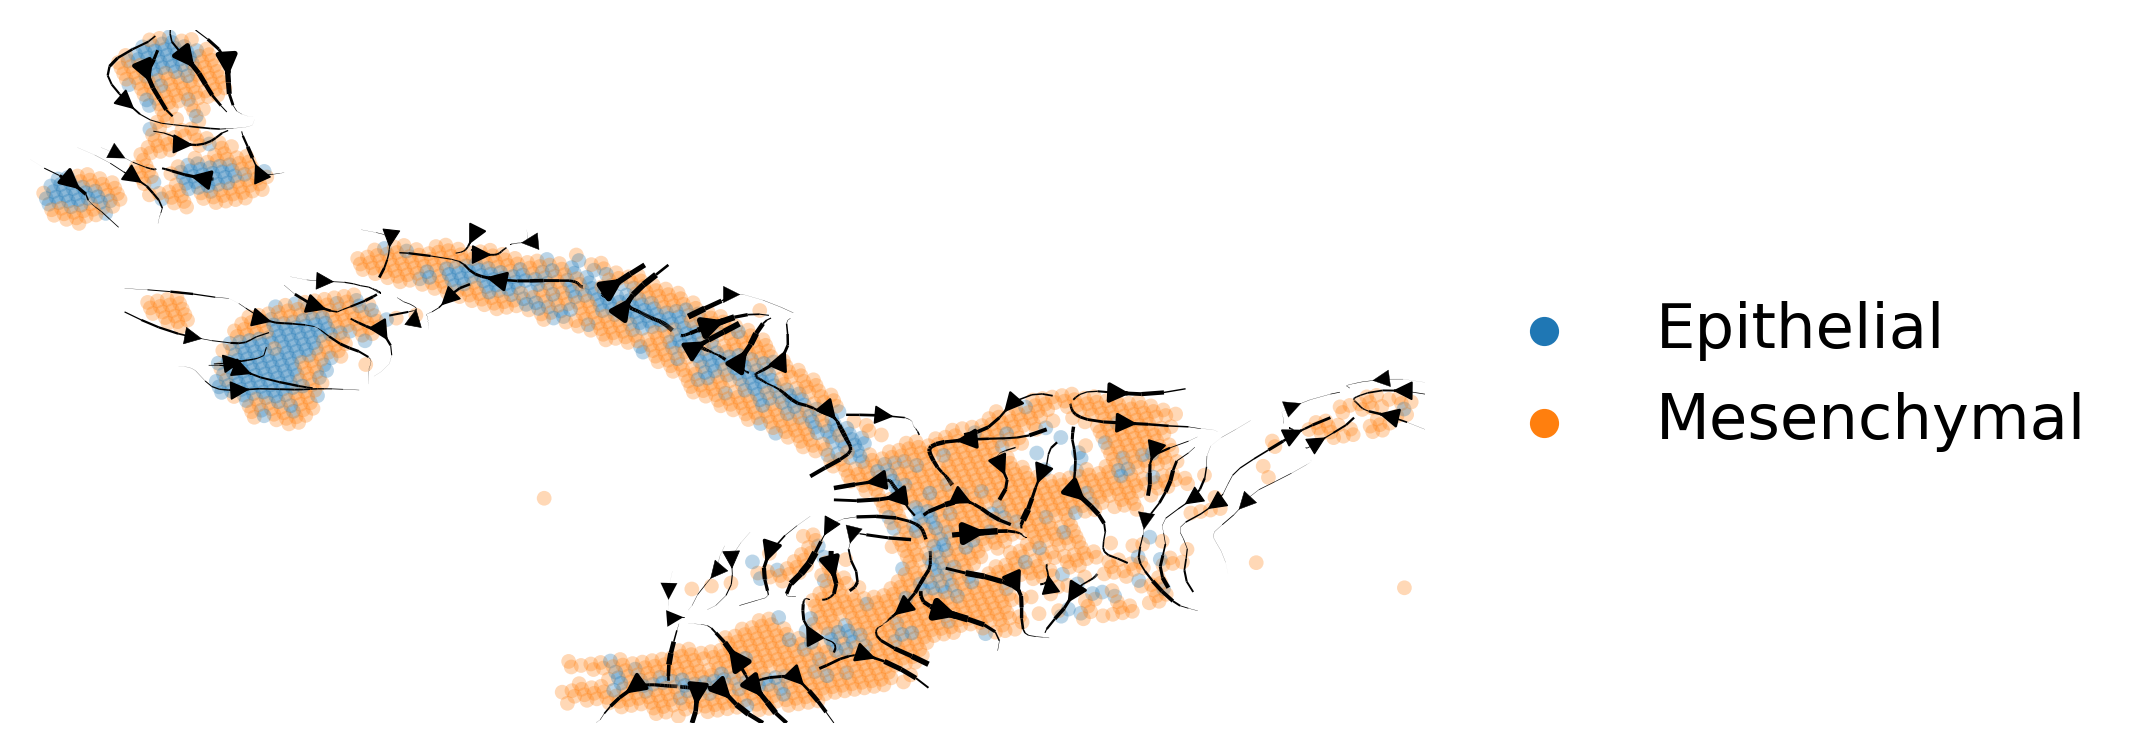

saving figure to file /nfs/turbo/umms-welchjd/yichen/figures/TopoVelo/stereo_seq/gut_e10.5_13.5/batchcorrected_gut_e13.5_gat_true_velocity.png


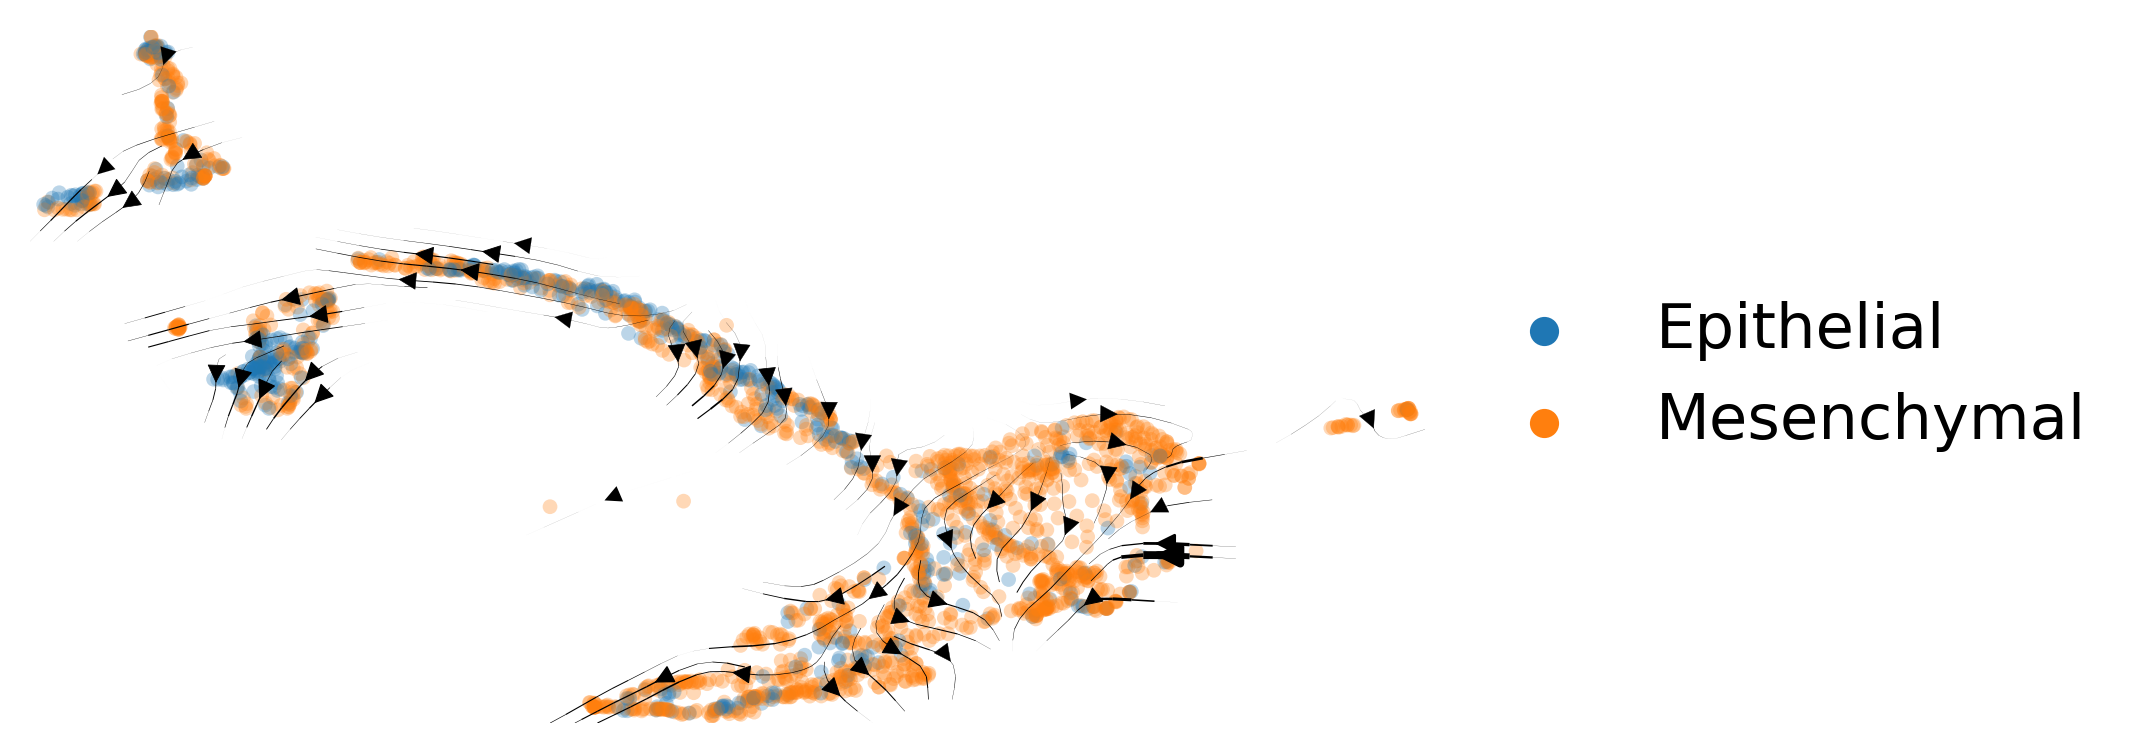

In [15]:
# del adata.obs['tprior']
slice_label = adata.obs['batch'].to_numpy()
for i, slc in enumerate(['0', '1', '2', '3']):
    adata_sub = adata[slice_label == slc]
    print(f"Sparisty: u={np.mean(adata_sub.layers['Mu'] == 0):.3f}"
          f"s={np.mean(adata_sub.layers['Ms'] == 0):.3f}")
    scv.pp.neighbors(adata_sub)
    (res, res_type,
     res_multi, res_multi_type) = tpv.post_analysis(adata_sub,
                                                    f'batchcorrected_gut_e{10.5+i}',
                                                    ['TopoVelo (GAT)'],
                                                    ['gat'],
                                                    spatial_graph_key='spatial_graph',
                                                    spatial_key='X_spatial',
                                                    compute_metrics=False,
                                                    spatial_velocity_graph=True,
                                                    embed='spatial',
                                                    plot_type=['stream'],
                                                    stream_figsize=(6, 3),
                                                    dpi=300,
                                                    stream_legend_loc='right margin',
                                                    figure_path=figure_path_base)
    # perf_logger.insert(f'Gut E{10.5+i}', res, res_type, res_multi, res_multi_type)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
['Snapc3']
---   Plotting  Results   ---
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
['Snapc3']
---   Plotting  Results   ---
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
['Snapc3']
---   Plotting  Results   ---
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
['Snapc3']
---   Plotting  Results   ---


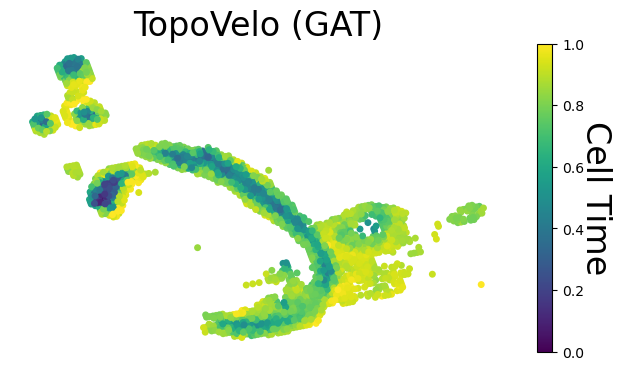

In [14]:
# del adata.obs['tprior']
for i, slc in enumerate(['0', '1', '2', '3']):
    adata_sub = adata[slice_label == slc]
    scv.pp.neighbors(adata_sub)
    (res, res_type,
     res_multi, res_multi_type) = tpv.post_analysis(adata_sub,
                                                    f'batchcorrected_gut_e{10.5+i}',
                                                    ['TopoVelo (GAT)'],
                                                    ['gat'],
                                                    spatial_graph_key='spatial_graph',
                                                    spatial_key='X_spatial',
                                                    compute_metrics=False,
                                                    spatial_velocity_graph=True,
                                                    embed='spatial',
                                                    plot_type=['time'],
                                                    dot_size=25,
                                                    time_colormap='viridis',
                                                    dpi=300,
                                                    figure_path=figure_path_base)

In [14]:
from umap import UMAP
z_umap = UMAP().fit_transform(adata.obsm['gat_z'])